In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

#For visualizing trees:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

*Tree-based* methods involve stratifying the feature space into several regions. These models are simple and useful for interpretation, but they don't perform as well as other methods in terms of prediction accuracy. However, the combination of a large number of trees can improve accuracy at the expense of interpretability.

### **Regression Trees**

**General Setup**

1. We divide the feature space into $J$ distinct and non-overlapping regions $R_1,R_2,...,R_J$.
2. For every observation that falls into some region $R_i$ for $i=1,2,...J$, we make the same prediction: the mean of the response values for the training observations in $R_i$.

The regions can have any shape in principle. **By convention, we divide them into "high-dimensional rectangles," or *boxes***, for simplicity and interpretation. The goal is to find the boxes $R_1,R_2,...,R_J$ that minimize

$$RSS=\sum^J_{J=1} \sum_{i \in R_J} (y_i - \hat{y}_{R_J})^2$$

where $\hat{y}_{R_J}$ is the mean response for the training observations within the $jth$ box.

Suppose we only have two features $X_1$ and $X_2$ that we divided $7$ regions $R_1,R_2,...,R_7$, then a decision tree will look something like this:

![picture](https://github.com/teddyjesus/treeBasedMethods/blob/master/decisionTreeGraphic.png)

In practice, it's inefficient to consider every possible partition of the feature space into $J$ boxes. Instead, we take a "top-down, greedy approach" known as recursive binary splitting.

**Recursive Binary Splitting**

1. We first select the feature $X_j$ and the cutpoint $s$ such that splitting the feature space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest reduction in $RSS$.

  - Considering all features $X_1,X_2,...,X_p$ and all possible cutpoints $s$ for each feature, the feature and cutpoint that results in the lowest $RSS$ is chosen. 

For any $j$ and $s$, let the **half-planes** be defined as

$$R_1(j,s)=\{X|X_j < s\}$$ $$and$$ $$R_2(j,s)=\{X|X_j \geq s\}$$

Then, we seek the value of $j$ and $s$ that minimizes

$$\sum_{i=x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i=x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2$$

2. The process above is repeated as we look for the best feature and cutpoint in order to further split the data for the lowest $RSS$, but this time one of the two previously identified regions is split. Now having three regions in total, we again split one of them into two (and so on). This continues until a **stopping criterion** is reached (i.e., until no region contains more than five observations). 

**Recursive binary splitting may produce good predictions on the training data, but is likely to suffer from overfitting due to the tree being too complex.** At the expense of slightly greater bias, a smaller tree with fewer regions might lead to a lower variance. 

*Alternative 1:* Build a tree only so long as the decrease in $RSS$ due to each split exceeds some threshold. This yields smaller trees. However, it may be the case that there is a split later on that leads to a significant reduction in $RSS$. 

*Alternative 2:* Grow a very large tree $T_0$, then prune it back in order to obtain a subtree. This approach is known as tree pruning.

Consider *Alternative 2* for creating decision trees where we select a subtree with the lowest test error rate. Given a subtree, the test error can be estimated using cross-validation. However, it's too complex to consider all possible subtrees. 

Instead, through **cost-complexicity tree pruning**, a small set of subtrees indexed by a nonnegative **tuning parameter** $\alpha$ can be taken into consideration. 

**The Algorithm Behind Building Regression Trees**

1. Grow a large tree $T_0$ on the training data using recursive binary splitting, stopping only when each **terminal node** has fewer than some minimum number of observations (the stopping criterion).
2. Obtain a sequence of best subtrees as a function of the tuning parameter $\alpha$ using cost-complexicity tree pruning.
3. Choose $\alpha$ using $K$-fold cross-validation. For each $k=1,2,...K$:

  - Repeat Steps $1$ and $2$ on all but the $kth$ fold of the training data.
  - Evaluate the mean squared prediction error on the test data in the left-out $kth$ fold as a function of $\alpha$.

Average the results for each value of $\alpha$ and pick the one that minimizes the average error.

4. Choose the subtree from Step $2$ that corresponds to the chosen $\alpha$.

Note that for each $\alpha$, there corresponds a subtree $T \subset T_0$ such that

$$ \sum^{|T|}_{m=1} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_1})^2 + \alpha|T|$$

is as small as possible. 

- $|T|$ is the number of terminal nodes of $T$. 
- $R_m$ is the rectangle/box (the subset of feature space) that corresponds to the $mth$ terminal node

**$\alpha$ controls the trade-off between the subtree's complexicity and its fit to the training data. Notice that $T = T_0$ when $\alpha=0$.**

**Short Demo: Predicting the Salary of Major League Baseball Players**

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/teddyjesus/treeBasedMethods/master/Hitters.csv")
data.rename(columns={"Unnamed: 0":"Player"},inplace=True)

data=data.dropna()
data["logSalary"] = np.log(data["Salary"])
data.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,logSalary
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N,6.163315
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A,6.173786
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N,6.214608
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N,4.516339
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A,6.620073


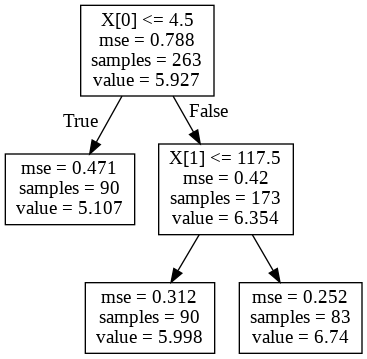

In [3]:
model = "logSalary ~ Years + Hits"
y, X = patsy.dmatrices(model, data, return_type="dataframe")
X = X.drop('Intercept',axis=1) #Intercepts don't apply to decision trees, so remove them from the feature space.

regr = DecisionTreeRegressor(max_leaf_nodes=3) #initiates the decision tree algorithm with leaf nodes no more than 3
model = regr.fit(X,y) #model fitting

#Visualization (https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)
dot_data = StringIO()
export_graphviz(model,out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### **Classification Trees**

Classification trees are similar in many respects to regression trees, except that they're used to predict a qualitative response. 

- Instead of the mean response as in the case of regression trees, the prediction for a given observation is the most commonly occuring class of training observations in the region to which it belongs.
- Instead of the $RSS$, recursive binary splitting uses the **classification error rate** $E$, the fraction of the training observations in a given region that don't belong to the most common class within it:

$$E = 1 - max_k(\hat{p}_{mk})$$

where $\hat{p}_{mk}$ is the proportion of training observations in the $mth$ region that are from the $kth$ class. Note that $E$ has been shown to not be "sufficiently sensitive" for building classification trees. 

**There are two preferred alternatives to $E$:**

1. The **Gini index** measures the total variance across the $K$ classes. It is a measure of **node purity**. The smaller the Gini index, the more there are observations of the same class within a node.

$$G = \sum^K_{k=1} \hat{p}_{mk}(1 - \hat{p}_{mk})$$

2. **Entropy**

$$D = -\sum^K_{k=1} \hat{p}_{mk}log\hat{p}_{mk}$$

It turns out that $G$ and $D$ are similar numerically, and either one can be used for recursive binary splitting. Both are more sensitive to node purity than $E$. **In classification trees, we want the nodes to be as pure as possible; that is, there are as much of the same classes within each node as possible (node purity). A small Gini index or entropy indicates high node purity.** 

There is no need to create dummy variables for categorical features in both regression and classification trees.



Advantages and Disadvantages of Decision Trees

- Easy to explain and closely mirrors human decision making ($+$)
- Interpretability and visualization ($+$)
- Higher prediction error than other models ($-$)
- Non-robust and unstable to small changes in the data ($-$)

**At the expense of interpretability, there are three methods that can significantly improve the prediction accuracy of decision trees:**

1. bagging
2. boosting
3. random forests

